# Demo of ATS1 benchmark using Jupyter Notebook

This is a demo of FalCAuN on Jupyter Notebook using the [kotlin-jupyter kernel](https://github.com/Kotlin/kotlin-jupyter). This demo assumes that `jupyter` is executed with the following environmental variables.

- `JAVA_HOME` (the java home for Java 11)
- `KOTLIN_JUPYTER_JAVA_OPTS="-Djava.library.path=$MATLAB_HOME/bin/maca64/:$MATLAB_HOME/bin/maci64:$MATLAB_HOME/bin/glnxa64"`

## Dependent packages

This notebook depends on FalCAuN-core and FalCAuN-matlab

In [1]:
@file:DependsOn("net.maswag:FalCAuN-core:1.0-SNAPSHOT")
@file:DependsOn("net.maswag:FalCAuN-matlab:1.0-SNAPSHOT")

## Automatic transmission model

The following shows the common configuration to run the Automatic Transmission benchmark [Hoxha et al., ARCH@CPSWeek 2014].

* [Hoxha et al., ARCH@CPSWeek 2014]: *Benchmarks for Temporal Logic Requirements for Automotive Systems*, ARCH@CPSWeek 2014, Bardh Hoxha, Houssam Abbas, Georgios E. Fainekos

In [2]:
import net.maswag.*

val initScript = """
versionString = version('-release');
oldpath = path;
path(strcat(userpath, '/Examples/R', versionString, '/simulink_automotive/ModelingAnAutomaticTransmissionControllerExample/'), oldpath);

mdl = 'Autotrans_shift';
load_system(mdl);
"""
val paramNames = listOf("throttle", "brake")
val signalStep = 5.0
val simulinkSimulationStep = 0.0025

In [3]:
// Load the automatic transmission model. This must be manually closed!!
val sul = SimulinkSUL(initScript, paramNames, signalStep, simulinkSimulationStep)

## Definition of the STL properties

In [4]:
import java.io.BufferedReader
import java.io.StringReader

// Define the input and output mappers
val throttleValues = listOf(0.0, 100.0)
val brakeValues = listOf(0.0, 325.0)
val inputMapper = InputMapperReader.make(listOf(throttleValues, brakeValues))
val ignoreValues = listOf(null)
val velocityValues = listOf(20.0, 40.0, 60.0, 80.0, 100.0, 120.0, null)
val accelerationValues = listOf(null)
val gearValues = listOf(null)
val outputMapperReader = OutputMapperReader(listOf(ignoreValues, accelerationValues, gearValues, velocityValues))
outputMapperReader.parse()
val mapperString = listOf("previous_max_output(0)").joinToString("\n")
val signalMapper: ExtendedSignalMapper = ExtendedSignalMapper.parse(BufferedReader(StringReader(mapperString)))
assert(signalMapper.size() == 1)
val mapper =
    NumericSULMapper(inputMapper, outputMapperReader.largest, outputMapperReader.outputMapper, signalMapper)

In [5]:
import net.maswag.TemporalLogic.STLCost;

// Define the STL properties
val stlFactory = STLFactory()
val stlList: List<STLCost> = listOf(
    "[] (signal(3) < 120)",
).map { stlString ->
    stlFactory.parse(
        stlString,
        inputMapper,
        outputMapperReader.outputMapper,
        outputMapperReader.largest
    )
}.toList()
val signalLength = 6
val properties = AdaptiveSTLList(stlList, signalLength)

## Configure the verifier

In [6]:
val verifier = NumericSULVerifier(sul, signalStep, properties, mapper)

// Timeout must be set before adding equivalence testing
verifier.setTimeout(5 * 60) // 5 minutes

### Configure the equivalence testing

In this demo, we use the equivalence testing based on an genetic algorithm. The following defines the constants.

In [7]:
// Constants for the GA-based equivalence testing
val maxTest = 50000
val populationSize = 200
val crossoverProb = 0.5
val mutationProb = 0.01

verifier.addGAEQOracleAll(
    signalLength,
    maxTest,
    ArgParser.GASelectionKind.Tournament,
    populationSize,
    crossoverProb,
    mutationProb
)

## Run the verifier

Then, we run the verifier. This takes some minutes.

In [8]:
val result = verifier.run()
result

false

In [9]:
println("Simulink execution time: ${verifier.simulationTimeSecond} [sec.]")
println("Simulink execution numbers: ${verifier.simulinkCount}")

Simulink execution time: 81.100077714 [sec.]
Simulink execution numbers: 0


In [10]:
import net.automatalib.word.Word;

var rawSignals = mutableListOf<IOContinuousSignal<List<Double>>>()
for (i in 0 until verifier.cexProperty.size) {
    val dim = mutableListOf<List<Double>>()
    for (j in 0 until verifier.cexConcreteInput[i].size()) {
        dim.add(verifier.cexConcreteInput[i].get(j))
    }
    val inputWord = Word.fromList(dim)
    rawSignals.add(sul.execute(inputWord))
}

## Print the result

The following prints some information about the falsified properties. Notice that 5 minutes is typically too short to falsify all the properties in ATS1, and some of them are still unfalsified.

In [11]:
// Print the result
for (i in 0 until verifier.cexProperty.size) {
    println("${verifier.cexProperty[i]} is falsified by the following counterexample)")
    println("cex concrete input: ${verifier.cexConcreteInput[i]}")
    println("cex abstract input: ${verifier.cexAbstractInput[i]}")
    println("cex abstract output: ${verifier.cexOutput[i]}")
}

[] ( output(3) < 120.000000 ) is falsified by the following counterexample)
cex concrete input: [0.0 100.0 0.0; 5.0 100.0 0.0; 10.0 100.0 0.0; 15.0 100.0 0.0; 20.0 100.0 0.0]
cex abstract input: ba ba ba ba ba
cex abstract output: aaaa aaad aaae aaaf aaag


## Plot the result

We can also plot the result of the falsification using `lets-plot`. We remark that we use the discrete-time semantics, and the results shown here are also rather coarsely sampled (by default, 1.0-time unit).

In [12]:
%use lets-plot

In [13]:
val bunch = GGBunch()
    for (i in 0 until verifier.cexProperty.size) {
        val size = verifier.cexConcreteInput[i].size()
        val datasetIn = mapOf(
            "time" to List(size) { it.toDouble() * signalStep } + List(size) { it.toDouble() * signalStep },
            "input" to verifier.cexConcreteInput[i].dimensionGet(0) + verifier.cexConcreteInput[i].dimensionGet(1),
            "group" to List(size) {"throttle"} + List(size) {"brake"}
        )
        bunch.addPlot(letsPlot(datasetIn) + 
                geomPath(showLegend = true) {x = "time"; y = "input"; color = "group"} +
                labs(title = "Input to falsify: " + verifier.cexProperty[i]), 0, 600 * i, 1000, 200)
        val outputSize = 3
        val outputLength = rawSignals[i].continuousOutputSignal.timestamps.size
        val velocityValues = rawSignals[i].continuousOutputSignal.values.map {triple -> triple[0]}
        val datasetVelocity = mapOf(
            "time" to rawSignals[i].continuousOutputSignal.timestamps,
            "output" to velocityValues,
            "group" to List(outputLength) { "velocity" }
        )
        bunch.addPlot(letsPlot(datasetVelocity) + 
                geomPath(showLegend = true) {x = "time"; y = "output"; color = "group"} +
                labs(title = "Output to falsify" + verifier.cexProperty[i]), 0, 800 * i + 200, 1000, 200)
        println("maximum value of velocity: ${velocityValues.max()}")
        println("minimum value of velocity: ${velocityValues.min()}")
    }
bunch.show()

maximum value of velocity: 120.21325006771389
minimum value of velocity: 0.0


## Render the learned Mealy machine

The learned Mealy machine can be rendered with Graphviz

In [14]:
import java.io.StringWriter

val dotWriter = StringWriter()
verifier.writeDOTLearnedMealy(dotWriter)

In [15]:
dotWriter.toString()

digraph g {

	s0 [shape="circle" label="s0"];
	s1 [shape="circle" label="s1"];
	s2 [shape="circle" label="s2"];
	s3 [shape="circle" label="s3"];
	s4 [shape="circle" label="s4"];
	s5 [shape="circle" label="s5"];
	s6 [shape="circle" label="s6"];
	s7 [shape="circle" label="s7"];
	s8 [shape="circle" label="s8"];
	s9 [shape="circle" label="s9"];
	s10 [shape="circle" label="s10"];
	s11 [shape="circle" label="s11"];
	s12 [shape="circle" label="s12"];
	s13 [shape="circle" label="s13"];
	s14 [shape="circle" label="s14"];
	s15 [shape="circle" label="s15"];
	s16 [shape="circle" label="s16"];
	s0 -> s0 [label="aa / aaaa"];
	s0 -> s1 [label="bb / aaaa"];
	s0 -> s0 [label="ab / aaaa"];
	s0 -> s3 [label="ba / aaaa"];
	s1 -> s1 [label="aa / aaac"];
	s1 -> s13 [label="bb / aaac"];
	s1 -> s1 [label="ab / aaac"];
	s1 -> s2 [label="ba / aaac"];
	s2 -> s14 [label="aa / aaae"];
	s2 -> s9 [label="bb / aaae"];
	s2 -> s8 [label="ab / aaae"];
	s2 -> s4 [label="ba / aaae"];
	s3 -> s6 [label="aa / aaad"];
	s3 -> 

In [16]:
@file:DependsOn("guru.nidi:graphviz-java:0.18.1")

import guru.nidi.graphviz.model.Factory.*
import guru.nidi.graphviz.*
import guru.nidi.graphviz.parse.*
import guru.nidi.graphviz.engine.*
import guru.nidi.graphviz.attribute.*

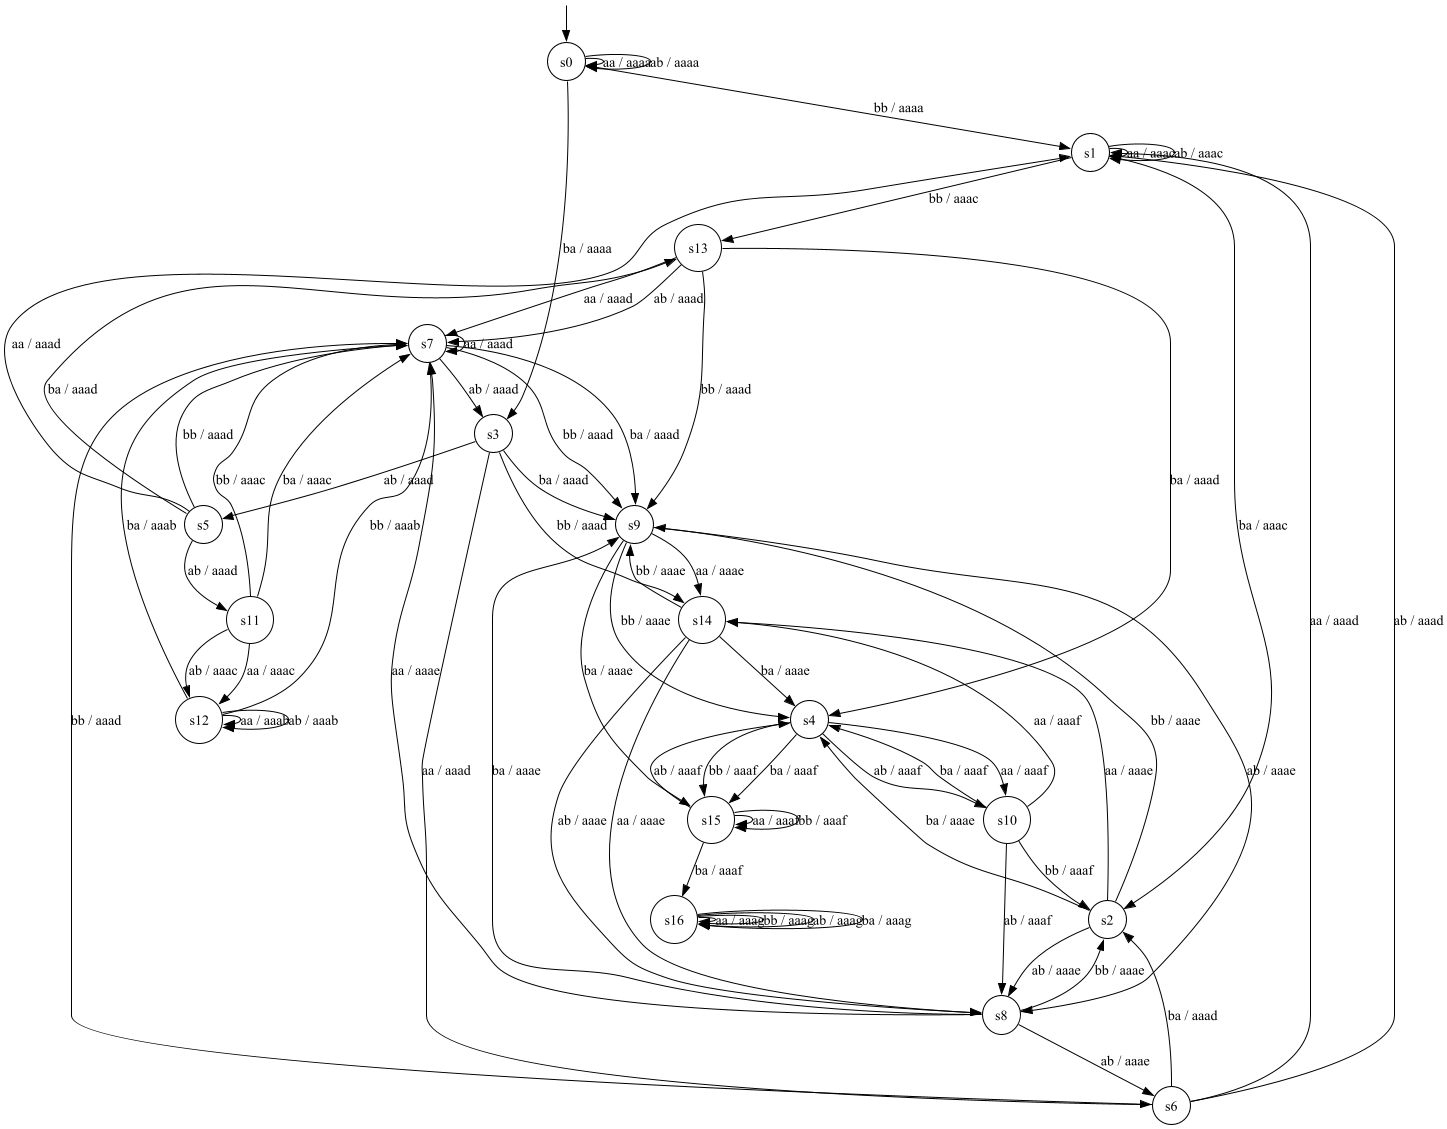

In [21]:
val graph = Parser().read(dotWriter.toString())
Graphviz.fromGraph(graph).render(Format.PNG).toImage()

We can emphasize the path highlighting the violation of the specification.

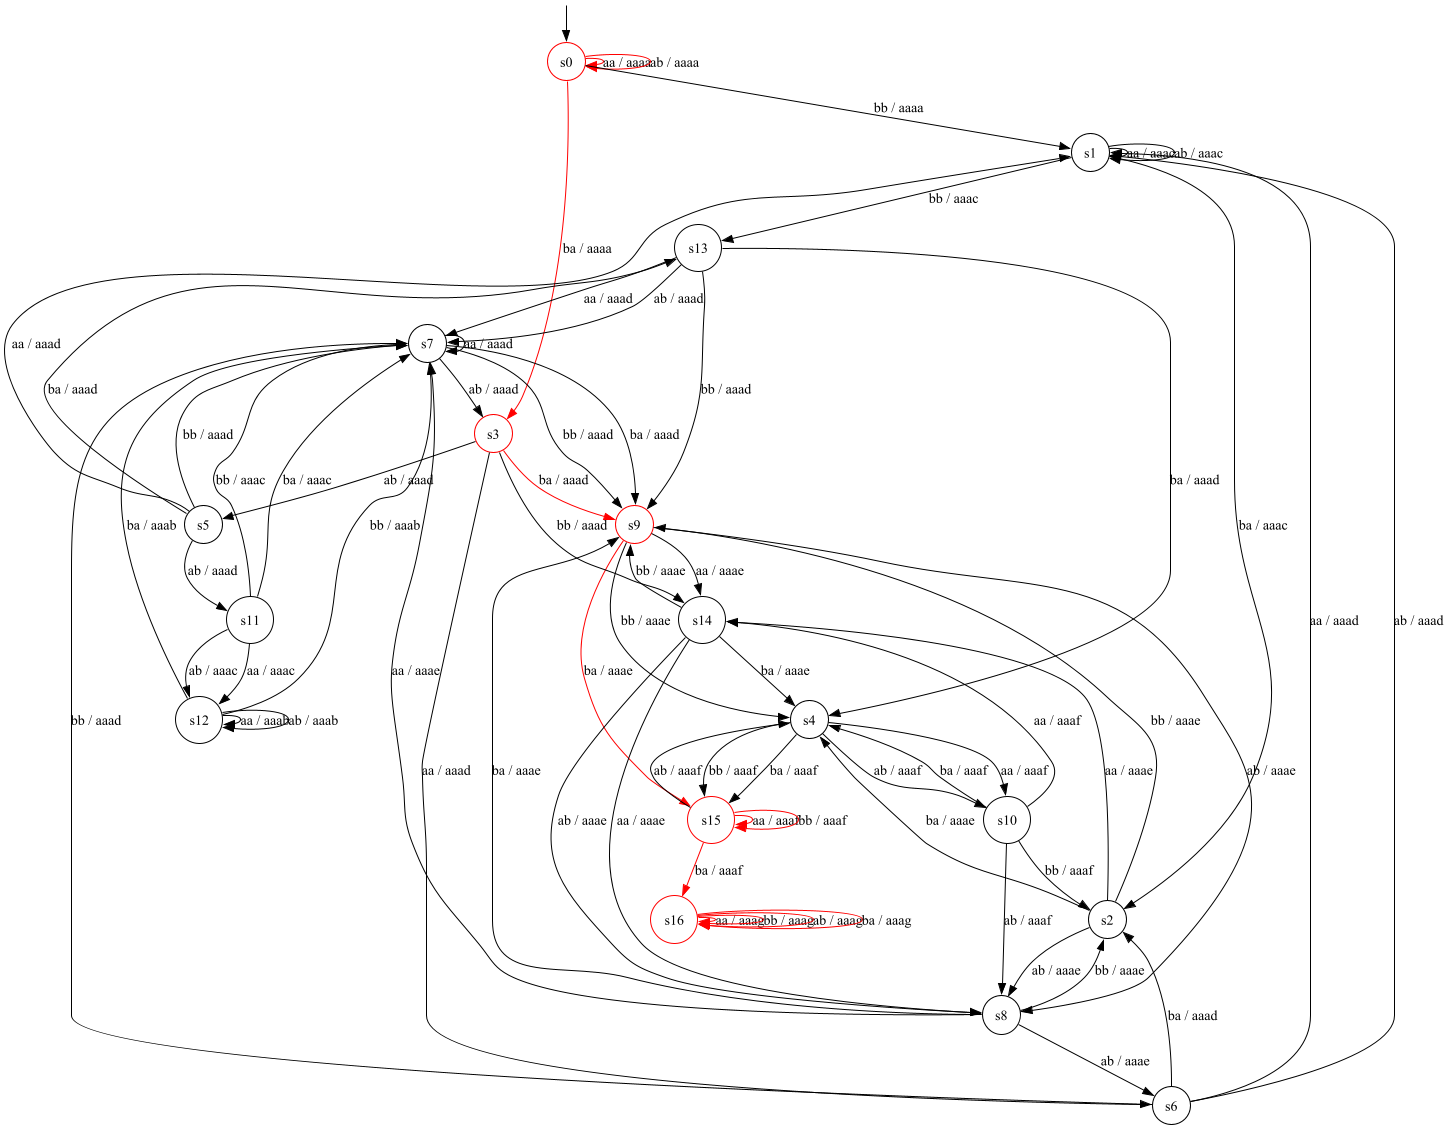

In [22]:
val criticalPath = listOf("s0", "s3", "s9", "s15", "s16") // This list must be manually updated
graph.nodes().forEach {node -> 
    if (criticalPath.contains(node.name().toString())) {
        // println(node.name())
        node.add(Color.RED)
    }
}
graph.edges().forEach { edge ->
    if (criticalPath.contains(edge.from()?.name().toString()) && criticalPath.contains(edge.to()?.name().toString())) {
        edge.add(Color.RED)
    }
}
Graphviz.fromGraph(graph).render(Format.PNG).toImage()

## IMPORTANT!! Close MATLAB engine

The following terminates the MATLAB engine. This must be executed at the end. Otherwise, the MATLAB process remains running. If you want to run the Simulink model, you can just re-initialize it.

In [19]:
sul.close()